<a href="https://colab.research.google.com/github/GoginikariTharunTeja/PROJECT/blob/main/tharun405.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MAJOR PROJECT:SKIN CANCER DETECTION USING DEEP LEARNING**
# UNDER THE GUIDENCE OF USHA DESAI 
TEAM MEMBERS:
G.THARUN TEJA					20K45A0405,
MD. SANA MAHEEN				19K41A0418,
P. SUJEETH						19K41A0452,
K. VINEELA						20K45A0406,

SR UNIVERSITY

In [18]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import glob
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.regularizers import l2

DATASET

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
data_dir_train = pathlib.Path("/content/drive/MyDrive/MAJOR/dataset2.0/train")
data_dir_test = pathlib.Path("/content/drive/MyDrive/MAJOR/dataset2.0/test")

TRAINING IMAGES AND TESTING IMAGES COUNT

In [21]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

18027
1846


In [22]:
batch_size = 128
img_height = 180
img_width = 180

DATA DIVIDED FOR VALIDATION

In [23]:
train_ds = image_dataset_from_directory(data_dir_train, 
                                        seed = 123, 
                                        image_size=(img_height, img_width), 
                                        validation_split=0.2, 
                                        subset='training')

Found 18027 files belonging to 6 classes.
Using 14422 files for training.


In [24]:
val_ds = image_dataset_from_directory(data_dir_train, 
                                      seed = 123, 
                                      image_size=(img_height, img_width), 
                                      validation_split=0.2, 
                                      subset='validation')

Found 18027 files belonging to 6 classes.
Using 3605 files for validation.


LISTING THE NAMES IN THE DATASET IN ALPHABETIC ORDER

In [25]:
class_names = train_ds.class_names
print(type(class_names), class_names)


<class 'list'> ['basal cell carcinoma', 'benign melanoma', 'malignant melanoma', 'melanocytic nevi', 'nevus', 'seborrheic keratosis']


### Visualizing the training data

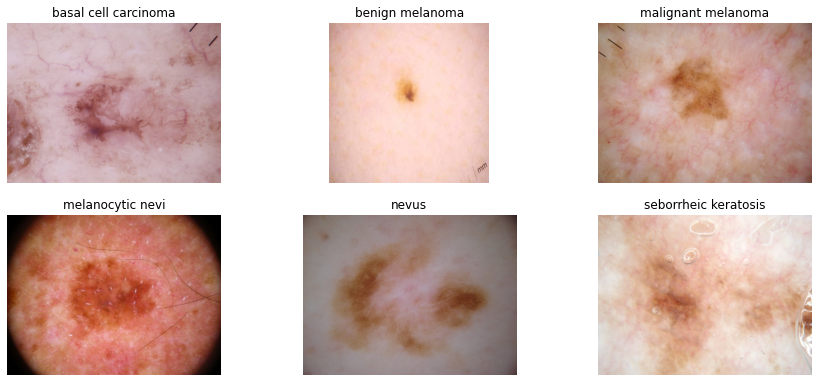

In [26]:
plt.figure(figsize=(15, 10))

for i, class_ in enumerate(list(class_names)):
    plt.subplot(3, 3, i+1)
    data_path = os.path.join(str(data_dir_train), class_)
    file_path = glob.glob(os.path.join(data_path,'*.jpg'))[0]
    img = PIL.Image.open(file_path)
    plt.imshow(img)
    plt.title(class_)
    plt.axis("off")
plt.show()

In [27]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [28]:
# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [29]:
data_augmentation = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

In [30]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

TypeError: ignored

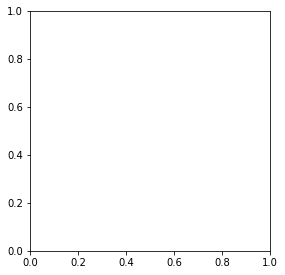

In [16]:
plt.figure(figsize=(15, 15))
for images, label in train_ds.take(1):
    for i in range(15):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.title(class_names[label[i]])
        plt.axis("off")

In [31]:
num_classes = 6

# Building model with data augmentation and drop out layers
# Model building - Data augmentation -> Rescaling -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Conv2D -> MaxPooling2D -> Dropout -> Dense -> Dense
model = data_augmentation
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)))
model.add(Conv2D(16, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(32, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D())
model.add(Dropout(0.15))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(num_classes))

In [32]:
## Your code goes here
model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 activation_4 (Activation)   (None, 180, 180, 16)      0         
                                                      

In [34]:
epochs = 50
callbacks=keras.callbacks.ModelCheckpoint("bestmodel.h5",save_best_only=True)
history = model.fit(train_ds,validation_data=val_ds,callbacks=callbacks,epochs=epochs)

Epoch 1/50
451/451 [==============================] - 328s 639ms/step - loss: 1.1036 - accuracy: 0.5898 - val_loss: 0.9481 - val_accuracy: 0.6338
Epoch 2/50
451/451 [==============================] - 18s 41ms/step - loss: 0.8703 - accuracy: 0.6806 - val_loss: 0.8856 - val_accuracy: 0.6760
Epoch 3/50
451/451 [==============================] - 18s 40ms/step - loss: 0.8155 - accuracy: 0.7017 - val_loss: 0.8675 - val_accuracy: 0.6799
Epoch 4/50
451/451 [==============================] - 18s 40ms/step - loss: 0.7776 - accuracy: 0.7109 - val_loss: 0.7218 - val_accuracy: 0.7379
Epoch 5/50
451/451 [==============================] - 20s 44ms/step - loss: 0.7443 - accuracy: 0.7245 - val_loss: 0.7317 - val_accuracy: 0.7409
Epoch 6/50
451/451 [==============================] - 18s 40ms/step - loss: 0.7065 - accuracy: 0.7411 - val_loss: 0.6830 - val_accuracy: 0.7459
Epoch 7/50
451/451 [==============================] - 18s 40ms/step - loss: 0.6856 - accuracy: 0.7480 - val_loss: 0.6828 - val_accurac

PLOTTING ACCURACY AND VALIDATION GRAPH

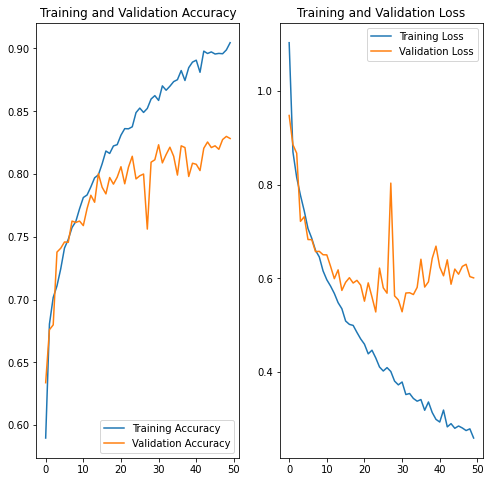

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
class_size = {}

for name in class_names:
    class_size[name] = len(list(data_dir_train.glob(name+'/*.jpg')))

class_size

{'basal cell carcinoma': 1007,
 'benign melanoma': 5000,
 'malignant melanoma': 5000,
 'melanocytic nevi': 5000,
 'nevus': 1016,
 'seborrheic keratosis': 1004}

In [37]:
class_df = pd.DataFrame(class_size.items(),index=list(class_size), columns = ['ClassName', 'NumberOfSamples'])
class_df.drop(['ClassName'], axis = 1, inplace=True)
class_df

,NumberOfSamples
basal cell carcinoma,1007
benign melanoma,5000
malignant melanoma,5000
melanocytic nevi,5000
nevus,1016
seborrheic keratosis,1004


BAR GRAPH FOR DATASET IMAGES

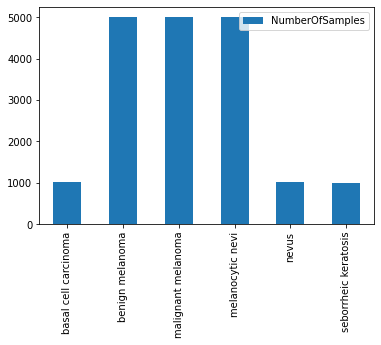

In [38]:
class_df.plot.bar()
plt.show()

In [39]:
test_dataset = image_dataset_from_directory(data_dir_test, image_size=(img_height, img_width), 
                                           batch_size=batch_size)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 1846 files belonging to 6 classes.


TESTING THE OUTPUTS BY TESTING DATASET

Predictions:
 [3 2 2 3 3 3 3 3 2 2 3 2 3 2 2 2 3 2 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 2 3 2 3
 2 2 2 3 2 3 2 2 3 3 3 3 2 3 3 3 3 3 3 2 3 3 3 3 3 2 3 2 3 3 3 2 2 3 3 3 2
 2 2 3 3 3 2 2 2 3 3 3 3 2 2 2 3 3 2 2 2 3 2 3 2 2 3 3 3 3 2 2 3 2 3 3 2 2
 2 3 3 3 2 2 2 3 2 3 2 2 3 3 3 2 3 3 3 2 3 3 3 2 3 2 2 3 2 2 2 3 3 3 2 3 2
 3 3 3 2 3 3 3 3 3 2 2 2 3 3 2 3 3 3 3 3 2 3 3 3 2 3 3 2 2 2 3 2 2 3 3 3 3
 2 3 2 2 3 3 3 3 2 3 2 3 3 3 3 2 2 3 2 3 3 2 3 3 3 3 2 2 2 3 2 3 2 2 3 3 3
 3 3 2 3 3 3 3 3 2 2 2 2 3 2 3 2 3 2 3 3 2 3 3 3 3 3 2 3 3 2 3 3 2 2 3 2 3
 3 2 2 3 2 3 2 2 3 3 3 3 2 2 2 3 3 3 3 2 2 3 2 2 3 2 3 3 3 2 3 2 2 3 3 2 3
 3 3 2 2 3 3 2 3 3 2 3 2 3 2 3 2 3 2 2 2 3 2 2 2 3 3 3 3 3 2 2 2 3 3 3 3 2
 3 3 3 2 3 3 3 2 2 3 2 2 2 3 3 2 3 3 2 2 2 3 3 3 2 3 2 3 3 3 3 2 2 3 3 3 3
 2 2 3 3 2 3 3 3 3 3 2 3 3 3 3 3 2 2 3 2 3 2 2 3 3 3 3 2 2 2 3 2 3 2 2 2 3
 3 3 3 2 3 3 3 3 2 2 2 2 3 3 2 2 2 3 3 3 3 2 2 3 2 3 2 3 2 3 2 3 3 3 2 2 3
 3 2 2 3 3 3 3 3 2 3 3 2 3 2 2 2 3 3 3 2 2 2 3 3 3 2 2 3 3 3 3 2 2 3 3 3 3
 2 3 2 3 2 

ValueError: ignored

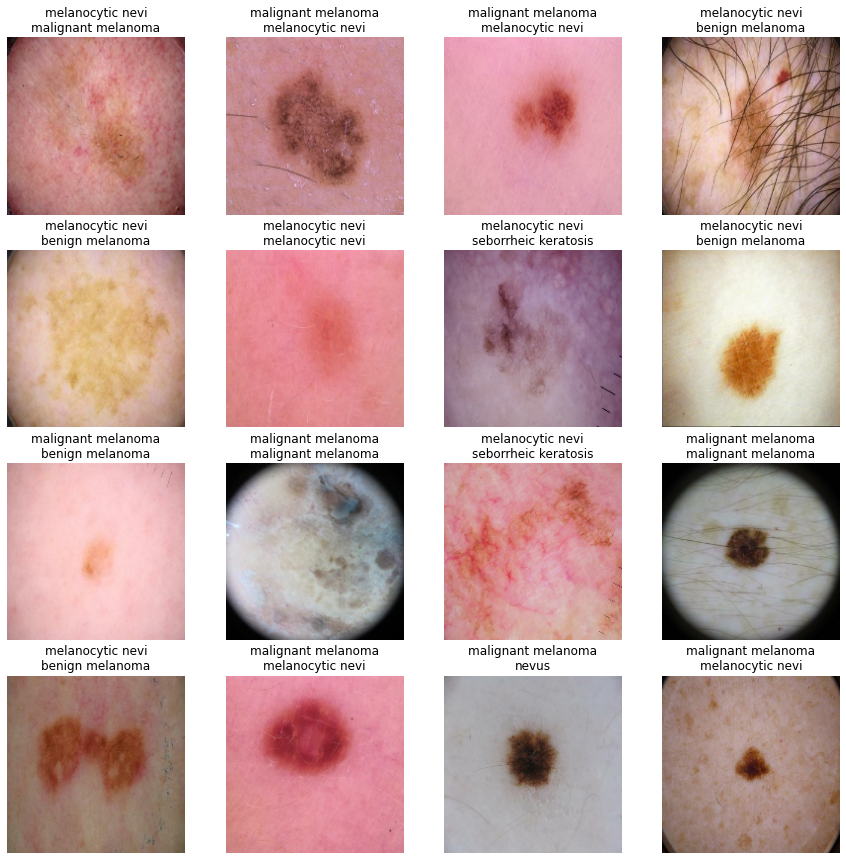

In [45]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 3, 2)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(15, 15))
for i in range(50):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

Predictions:
 [3 2 2 3 3 3 3 2 2 2 3 2 3 2 2 2 3 3 3 2 2 2 3 3 3 2 2 3 3 3 3 2 2 2 3 3 3
 2 2 2 3 3 3 2 3 3 3 3 3 3 2 3 2 2 2 3 3 3 3 2 3 3 2 3 3 2 3 2 2 3 3 3 3 3
 2 3 2 3 3 3 2 2 3 2 3 2 3 2 3 3 3 2 2 3 3 3 3 3 2 3 3 2 3 2 2 3 3 3 3 2 3
 2 3 3 3 2 2 2 3 3 3 3 2 3 3 2 3 2 2 3 3 3 3 3 2 3 3 3 3 2 2 2 3 3 3 2 2 2
 3 3 3 2 2 2 3 3 3 3 2 2 3 2 3 2 2 2 3 2 3 2 2 3 3 3 3 3 2 2 3 3 3 2 2 3 3
 2 3 3 2 3 3 3 3 2 2 3 3 3 2 3 3 3 2 2 2 2 3 3 3 3 3 2 2 2 3 3 2 2 3 3 3 3
 3 2 2 2 3 3 3 2 2 2 3 2 3 2 2 2 3 3 3 2 2 3 2 3 2 3 2 2 3 3 3 3 2 2 2 2 3
 2 3 2 3 2 3 2 2 2 3 3 3 2 2 2 3 2 3 3 2 3 3 3 3 2 2 2 3 2 3 3 2 2 3 2 3 2
 2 3 3 3 3 2 2 2 3 3 3 2 2 3 3 2 3 2 2 2 3 3 3 3 2 2 3 2 3 2 2 2 3 3 3 3 3
 3 2 3 2 3 3 2 3 2 3 2 3 2 3 3 3 3 2 3 2 2 3 3 2 2 3 2 3 2 2 3 3 3 3 3 3 2
 3 2 2 3 2 2 3 2 3 2 2 3 3 3 3 2 2 2 3 3 3 2 2 2 3 2 3 2 2 2 3 2 3 2 2 3 3
 3 3 3 2 2 2 2 3 2 3 2 3 2 3 3 3 3 2 2 3 3 3 2 2 3 3 2 2 2 3 3 3 2 2 2 3 2
 3 3 2 2 2 2 3 3 2 3 3 2 3 2 2 3 3 3 3 2 2 3 3 3 3 2 2 2 3 2 3 2 2 2 3 3 3
 2 2 2 2 3 

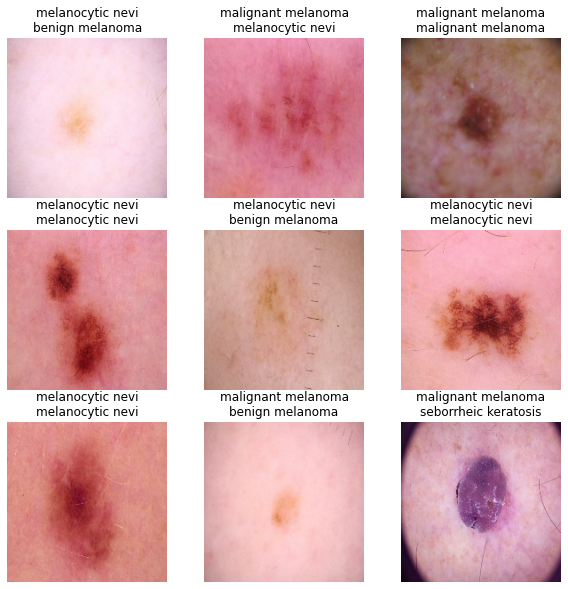

In [46]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 3, 2)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

Predictions:
 [1 1 3 1 3 3 1 1 3 3 1 3 1 1 3 3 3 3 1 3 1 1 1 1 1 3 3 1 1 1 1 3 1 3 1 1 1
 1 1 3 1 3 1 1 1 1 1 3 1 3 1 1 1 1 1 1 3 1 1 3 3 1 1 3 1 1 1 1 1 1 1 3 1 1
 3 1 1 3 1 1 3 3 3 3 1 1 3 1 3 1 1 1 1 1 1 3 1 1 3 1 1 3 1 3 3 1 1 1 1 3 3
 3 1 3 1 3 3 3 1 1 1 3 3 1 1 1 1 1 3 1 1 1 1 1 3 1 1 1 1 3 3 1 1 1 1 1 3 1
 1 1 3 3 3 3 1 1 1 1 3 3 1 3 1 1 3 3 1 3 1 1 3 3 1 1 1 3 3 3 1 1 1 1 3 3 1
 3 1 1 3 3 1 1 1 3 3 3 1 1 1 3 3 1 1 1 3 1 1 1 1 1 1 3 1 3 1 3 3 1 1 1 3 1
 1 3 3 1 1 1 1 1 3 1 1 3 1 3 3 1 1 1 1 1 3 1 1 1 1 3 3 1 1 1 1 3 3 1 1 1 1
 1 3 1 1 3 1 3 1 3 1 1 3 1 1 1 3 1 1 3 1 1 1 1 1 1 3 3 1 3 1 1 1 1 1 3 1 3
 3 3 1 3 1 3 3 3 1 1 1 3 3 1 1 1 3 1 1 1 1 1 1 1 1 3 1 3 3 1 1 1 1 1 1 1 3
 1 1 1 1 1 3 3 1 1 1 3 3 1 1 1 1 1 3 1 1 1 1 3 3 1 1 1 1 1 1 1 3 3 1 3 3 3
 1 1 1 1 3 1 1 1 3 1 3 1 1 3 1 3 3 1 1 1 1 1 3 1 1 3 1 3 3 3 1 3 3 1 1 3 1
 3 1 3 1 1 1 3 1 3 3 1 1 1 1 1 3 3 1 3 1 3 3 3 1 1 1 1 3 1 1 1 1 1 3 3 1 3
 3 3 3 3 1 3 1 3 1 1 1 1 1 3 3 1 1 1 3 3 1 1 3 1 1 3 3 1 3 1 1 1 1 3 1 1 1
 3 3 1 1 1 

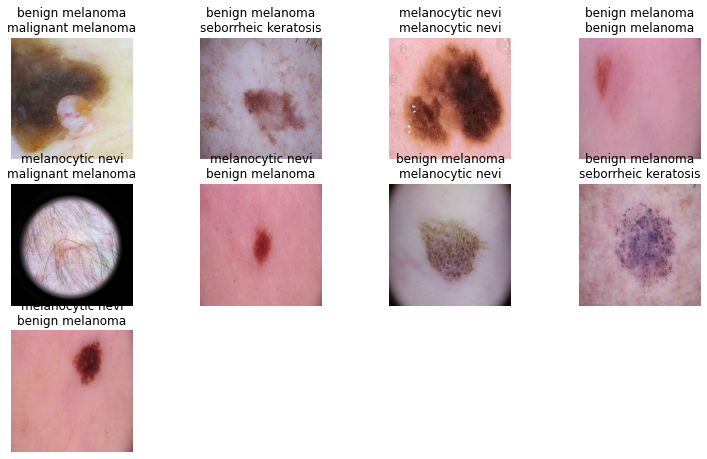

In [47]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.8, 1, 3)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

Predictions:
 [1 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 1 1 1 1 1 1 3 1 3 1 3 3 3 1 1 3
 3 1 1 1 1 1 3 3 1 1 1 1 3 1 3 1 1 1 3 1 3 1 1 1 3 3 1 1 1 1 1 3 3 1 3 1 1
 3 1 1 1 3 1 1 1 3 3 1 3 1 3 1 1 1 1 3 1 1 3 1 3 3 1 1 1 1 1 1 1 1 3 1 1 3
 1 1 1 1 3 3 1 1 1 1 1 1 3 1 3 1 1 3 1 1 1 1 3 3 1 1 1 1 1 1 1 3 1 1 3 3 3
 1 1 1 3 1 3 1 1 1 3 3 1 1 1 3 1 1 1 1 1 1 1 3 3 1 3 1 3 3 1 1 1 1 3 3 3 1
 3 1 1 3 3 1 1 1 3 1 3 1 1 1 1 1 1 1 1 1 3 3 1 1 1 1 3 1 1 1 1 1 1 3 1 1 1
 1 3 3 3 1 1 1 3 1 1 1 1 1 3 3 1 1 1 1 3 1 1 1 1 1 3 3 3 1 3 1 3 1 1 1 1 1
 3 1 3 1 1 1 3 1 1 1 1 3 1 1 1 1 1 1 3 1 3 1 1 1 3 3 1 1 1 1 1 1 1 1 1 1 3
 3 1 1 1 1 3 1 1 1 1 1 3 3 1 1 1 1 3 3 1 1 1 3 3 1 1 1 1 1 1 3 1 3 1 1 3 3
 1 1 1 1 1 1 3 1 3 1 1 3 3 1 1 1 3 3 1 1 1 1 1 1 1 1 3 1 1 3 3 1 3 1 1 3 3
 1 3 1 3 1 3 1 1 1 1 3 1 1 1 1 3 1 1 1 1 1 3 3 1 1 1 1 1 3 3 1 1 1 1 1 3 1
 1 1 3 3 1 1 1 1 1 3 3 1 1 3 1 1 1 3 3 1 3 3 1 1 1 1 1 3 3 3 1 3 1 1 1 1 1
 1 1 3 3 1 1 1 3 1 3 1 1 1 1 1 3 1 3 1 1 3 1 1 1 1 1 3 3 1 1 1 1 3 1 1 3 1
 1 3 1 1 1 

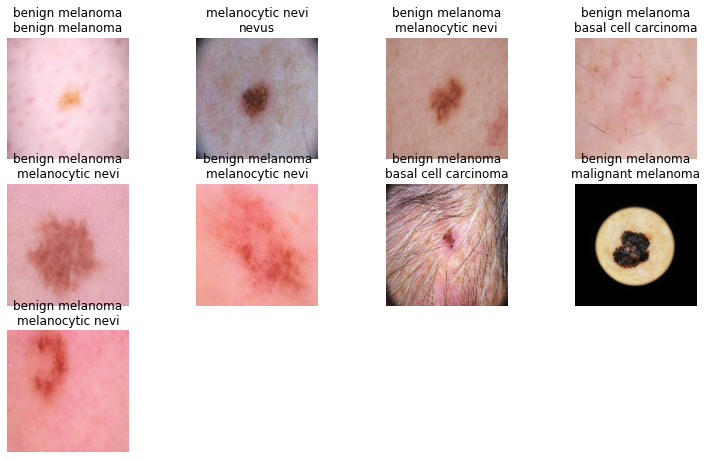

In [48]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.9, 1, 3)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

Predictions:
 [1 0 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 1 0 1 0 0 1 1 1 1
 0 0 0 1 1 0 1 1 1 1 0 1 0 0 0 1 1 1 1 1 0 1 0 0 0 1 0 1 0 1 1 0 0 1 1 1 0
 0 1 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0
 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 0 1
 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 1
 0 1 0 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 0 0 1 0
 1 1 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1
 0 0 0 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 0 0 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1
 1 0 1 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 0 0 1 1 1 0 1 0
 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 1 1 0 0 1
 1 1 1 1 0 1 1 1 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1 0 0 1 1
 1 1 1 0 1 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0
 1 1 0 0 1 0 0 1 1 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 1 1 1 1 0 0 0 1 0 1
 1 0 1 1 1 

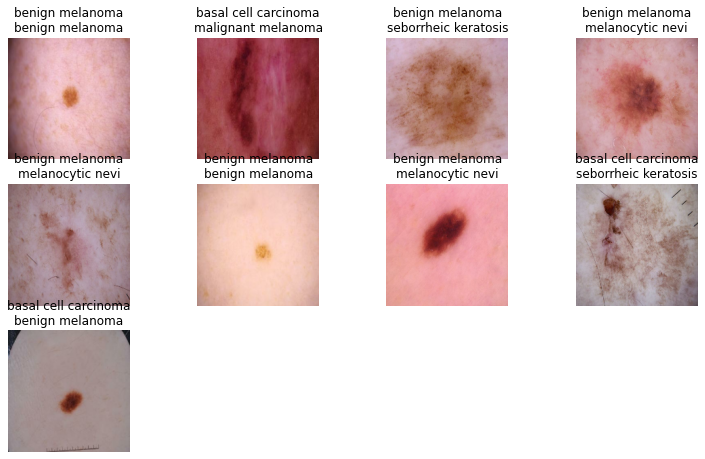

In [49]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.8, 1, 0)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

Predictions:
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 

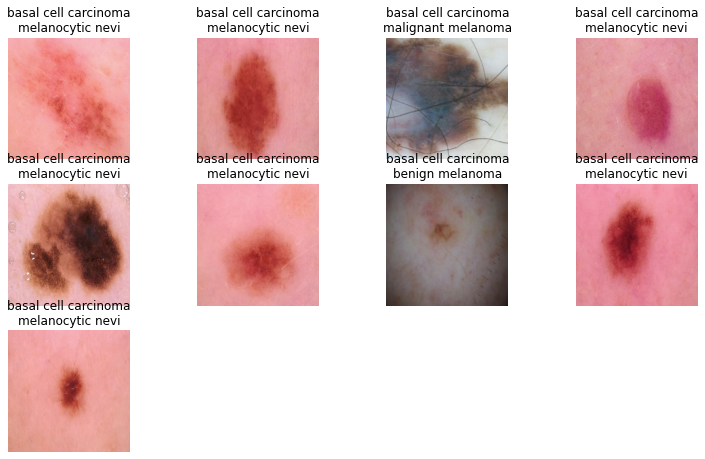

In [50]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 1, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(13, 13))
for i in range(9):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]] + "\n" + class_names[label_batch[i]])
    plt.axis("off")

In [51]:
model.save("tharun.h5")